# Work on coordinate conversions

## RAWXY to DETXY

Using `ecoordconv` to get the corners of each CCD as DETXY coordinates. The corners in RAWXY coordinates are fixed: (1,1), (600,600)


In [410]:
import os
import sys
import subprocess
import importlib 
import pandas as pd

import numpy as np

%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
#
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')


In [16]:
def run_command(command,verbose=True):
    #
    # Execute a shell command with the stdout and stderr being redirected to a log file 
    #
    try:
        result = subprocess.run(command, shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
        retcode=result.returncode
        if retcode < 0:
            if (verbose):
                print(f"Error: execution of {command} was terminated by signal", -retcode, file=sys.stderr)
        else:
            if (verbose):
                print(f"Info: execution of {command} returned", retcode, file=sys.stderr)
    except OSError as e:
        print(f"Execution of {command} failed:", e, file=sys.stderr)
    return retcode, result.stdout.decode()

In [10]:
#
# set up XMM-SAS
#
# the current one is 18.0 ==> /home/xcaldata/setsas_180.sh
# tests with XMM-SAS 16.1 for the arfgen
#!. /home/xcaldata/setsas_161.sh
#
sas_dir = "/sas/Linux/Ubuntu18.04/64/sas18_0_0"
#sas_dir = "/sas/Linux/RHEL_6.9Workstation/64/sas18_0_0"
#sas_dir = "/sas/Linux/RHEL_6.9Workstation/64/sas16_1_0"
os.environ["SAS_DIR"]= sas_dir
os.environ["SAS_PATH"]=os.environ["SAS_DIR"]
os.environ["SAS_VERBOSITY"]="4"
os.environ["SAS_SUPPRESS_WARNING"]="1"
path = os.environ["PATH"]
os.environ["PATH"] = f"{sas_dir}/bin:{sas_dir}/binextra:{path}"
ld_path = os.environ["LD_LIBRARY_PATH"]
lib_path = f"{sas_dir}/lib:{sas_dir}/libextra:{sas_dir}/libsys:{ld_path}"
os.environ["LD_LIBRARY_PATH"] = lib_path
#
# check
#print ("PATH = ",os.environ["PATH"])
#print ("LF_LIBRARY_PATH = ",os.environ["LD_LIBRARY_PATH"])
#for ikey in os.environ.keys():
#    if ('SAS' in ikey):
#        print (ikey," = ",os.environ[ikey])
!sasversion

sasversion:- Executing (routine): sasversion  -w 1 -V 4
sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] started:  2019-08-19T09:19:24.000
sasversion:- XMM-Newton SAS release and build information:

SAS release: xmmsas_20190531_1155-18.0.0
Compiled on: Sun Jun  2 14:11:18 CEST 2019
Compiled by: sasbuild@sasbld03n
Platform   : Ubuntu16.04 64

SAS-related environment variables that are set:

SAS_DIR = /sas/Linux/Ubuntu18.04/64/sas18_0_0
SAS_PATH = /sas/Linux/Ubuntu18.04/64/sas18_0_0
SAS_CCFPATH = /ccf/valid
SAS_CCF = /home/ivaltchanov/XMM/3XMM/ccf.cif

sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] ended:    2019-08-19T09:19:24.000


In [11]:
home = os.path.expanduser('~')
wdir = f'{home}/XMM/3XMM'
os.environ['SAS_CCFPATH'] = '/ccf/valid'
os.environ['SAS_CCF'] = f"{wdir}/ccf.cif"
#
# need an image, will use an arbitrary one
#
imset = f'{wdir}/0794581201/pps/P0794581201M1S001IMAGE_2000.FTZ'
#

In [33]:
#
# build a call to ecoordconv
#
raw_coord = [1,300,600]
ccds = np.arange(1,8)

fout = open(f'{wdir}/raxy_to_detxy_test.csv','w')
print ('ccdno,rawx,rawy,detx,dety,theta,phi',file=fout)
#
for ccdno in ccds:
    print (f"Doind MOS1 CCD #{ccdno}")
    for ix in raw_coord:
        rawx = ix
        for iy in raw_coord:
            rawy = iy
            comm = f'ecoordconv imageset={imset} x={rawx} y={rawy} coordtype=\'raw\' ccdno={ccdno}'
            #
            status, output = run_command(comm,verbose=False)
            if (status != 0):
                print ('Error: econvcoord failed!')
                raise Exception
            #
            else:
                for lines in output.splitlines():
                    if ('DETX:' in lines):
                        xx = lines.split()
                        detx = float(xx[2])
                        dety = float(xx[3])
                    if ('Theta:' in lines):
                        xx = lines.split()
                        theta = float(xx[2])
                        phi = float(xx[3])
                outx = f'{ccdno},{rawx},{rawy},{detx},{dety},{theta},{phi}'
                print (outx,file=fout)
#
fout.close()

Doind MOS1 CCD #1
Doind MOS1 CCD #2
Doind MOS1 CCD #3
Doind MOS1 CCD #4
Doind MOS1 CCD #5
Doind MOS1 CCD #6
Doind MOS1 CCD #7


In [34]:
df = pd.read_csv(f'{wdir}/raxy_to_detxy_test.csv')

In [35]:
df

,ccdno,rawx,rawy,detx,dety,theta,phi
0,1,1,1,-6593.573300,-6593.573300,462.475190,2.332630
1,1,1,300,-6593.573300,-10.971507,334.780550,1.541200
2,1,1,600,-6593.573300,6593.645700,477.151530,0.777242
3,1,300,1,-10.971507,-6593.573300,319.270610,3.124353
4,1,300,300,-10.971507,-10.971507,11.333116,0.507099
5,1,300,600,-10.971507,6593.645700,340.182310,0.016180
6,1,600,1,6593.645700,-6593.573300,455.358170,3.935538
7,1,600,300,6593.645700,-10.971507,324.878100,4.742888
8,1,600,600,6593.645700,6593.645700,470.256680,5.520962
9,2,1,1,13099.951000,-20147.005000,1190.106800,3.719420


In [43]:
isel = df.loc[(df.rawx != 300) & (df.rawy != 300)]

,ccdno,rawx,rawy,detx,dety,theta,phi
0,1,1,1,-6593.573300,-6593.5733,462.47519,2.332630
2,1,1,600,-6593.573300,6593.6457,477.15153,0.777242
6,1,600,1,6593.645700,-6593.5733,455.35817,3.935538
8,1,600,600,6593.645700,6593.6457,470.25668,5.520962
9,2,1,1,13099.951000,-20147.0050,1190.10680,3.719420
11,2,1,600,-87.267686,-20147.0050,996.93832,3.132245
15,2,600,1,13099.951000,-6959.7858,732.45069,4.233461
17,2,600,600,-87.268263,-6959.7864,337.66243,3.113992
18,3,1,1,19856.315000,-6898.8552,1042.95250,4.385908
20,3,1,600,6669.095500,-6898.8558,468.82158,3.917960


In [126]:
mcoefx = {}
mcoefy = {}
detx0 = {}
dety0 = {}
rawx0 = {}
rawy0 = {}
#
qsel = isel.loc[(isel.rawx == isel.rawy)]

for iccd in qsel.ccdno:
    pse = qsel.groupby("ccdno").get_group(iccd)
    x1x = pse.rawx.iat[0]
    x2x = pse.rawx.iat[1]
    y1x = pse.detx.iat[0]
    y2x = pse.detx.iat[1]
    detx0[iccd] = y1x
    rawx0[iccd] = x1x
    mcoefx[iccd] = (y2x-y1x)/(x2x-x1x)
    x1y = pse.rawy.iat[0]
    x2y = pse.rawy.iat[1]
    y1y = pse.dety.iat[0]
    y2y = pse.dety.iat[1]
    dety0[iccd] = y1y
    rawy0[iccd] = x1y
    mcoefy[iccd] = (y2y-y1y)/(x2y-x1y)
#

In [291]:
detx0,dety0

({1: -6593.5733,
  2: 13099.951000000001,
  3: 19856.315,
  4: 13163.421,
  5: -13003.676000000001,
  6: -19770.078,
  7: -13117.889},
 {1: -6593.5733,
  2: -20147.005,
  3: -6898.8552,
  4: 6428.8926,
  5: 19693.992,
  6: 6494.8849,
  7: -6864.6255})

In [402]:
mcoefx

{1: 22.015390651085145,
 2: -22.015391090150253,
 3: -22.01539248747913,
 4: -22.01539102337229,
 5: 22.015390000000004,
 6: 22.015389649415695,
 7: 22.01538894156928}

In [363]:
def raw2det_work(detector='mos1', rawx=1,rawy=1,ccdnr=1):
    #
    # direct calculation of RAWX, RAWY to DETX,DETY
    # only implemented for MOS1 for the moment
    #
    # CCD rotation signs
    signs = {1: [1,1], 2: [-1,1], 3: [-1,1], 4: [-1,1], 5: [1,-1], 6: [1,-1], 7: [1,-1]}
    #
    # reference values
    #
    detxy0 = {1: [-6593.5733,-6593.5733], \
              2: [13099.951,-20147.005], \
              3: [19856.315,-6898.8552], \
              4: [13163.421,6428.8926], \
              5: [-13003.676,19693.992], \
              6: [-19770.078,6494.8849], \
              7: [-13117.889,-6864.6255]}

    # slope coefficient
    mcoef = 22.0
    # additional offset coefficient for non-central CCDs
    coef = 9.219/600.0 
    dxraw = rawx-1
    dyraw = rawy-1
    detx = signs[ccdnr][0]*mcoef*dxraw + detxy0[ccdnr][0] + dxraw*coef
    dety = signs[ccdnr][1]*mcoef*dyraw + detxy0[ccdnr][1] + dyraw*coef
    if (ccdnr > 1):
        dxraw = (rawy-1)
        dyraw = (rawx-1)
        detx = signs[ccdnr][0]*mcoef*dxraw + detxy0[ccdnr][0] + signs[ccdnr][0]*dxraw*coef
        dety = signs[ccdnr][1]*mcoef*dyraw + detxy0[ccdnr][1] + signs[ccdnr][1]*dyraw*coef
    #
    return (detx,dety)

In [391]:
def get_theta_phi(detector='mos1',rawx=1,rawy=1,ccdnr=1,which='optical'):
    #
    # derive the off-axis distance (theta) and the azymuthal angle (phi) 
    # with respect to the centre of CCD1 (300,300) and also with respect to the optical axis.
    #
    # optical axis centre, taken from XMM_MISCDATA_0022.CCF
    #
    # theta is in arcsec, phi is in radians
    #
    if (which == 'optical'):
        adetx0,adety0 = raw2det_work(detector=detector,rawx=305,rawy=291,ccdnr=1)
    else:
        adetx0,adety0 = raw2det_work(detector=detector,rawx=300,rawy=300,ccdnr=1)
    #
    adetx,adety = raw2det_work(detector=detector,rawx=rawx,rawy=rawy,ccdnr=ccdnr)
    #
    # now the theta in arcsec
    theta = np.sqrt((adety-adety0)**2 + (adetx-adetx0)**2)*0.05
    phi = (np.arctan2(adety-adety0,adetx-adetx0) - np.pi/2.0) % (2*np.pi)
    #
    return theta,phi

In [404]:
sys.path.append(f"{home}/GitHub/xmmpy/scripts")

In [414]:
import get_theta_phi as wk
importlib.reload(wk)


<module 'get_theta_phi' from '/home/ivaltchanov/GitHub/xmmpy/scripts/get_theta_phi.py'>

In [415]:
#
# check the direct calculation 
#
raw_coord = [1,300,600]
ccds = np.arange(1,8)

fout = open(f'{wdir}/raxy_to_detxy_test_mine.csv','w')
print ('ccdno,rawx,rawy,detx,dety,theta,phi',file=fout)
#
#
for ccdno in ccds:
    print (f"Doind MOS1 CCD #{ccdno}")
    for ix in raw_coord:
        for iy in raw_coord:
            adetx,adety = wk.raw2det(detector='mos1', rawx=ix,rawy=iy,ccdnr=ccdno)
            ztheta,zphi = wk.get_theta_phi(detector='mos1',rawx=ix,rawy=iy,ccdnr=ccdno)
            print (f'{ccdno},{ix},{iy},{adetx},{adety},{ztheta},{zphi}',file=fout)
#
fout.close()

Doind MOS1 CCD #1
Doind MOS1 CCD #2
Doind MOS1 CCD #3
Doind MOS1 CCD #4
Doind MOS1 CCD #5
Doind MOS1 CCD #6
Doind MOS1 CCD #7


In [416]:
df1 = pd.read_csv(f'{wdir}/raxy_to_detxy_test.csv')
ix = [f'{x}_{y}' for x,y in zip(df1.rawx,df1.rawy)]
df1['id'] = ix
ix = [f'{x}_{y}' for x,y in zip(df1.ccdno,df1.id)]
df1['id'] = ix

df2 = pd.read_csv(f'{wdir}/raxy_to_detxy_test_mine.csv')
ix = [f'{x}_{y}' for x,y in zip(df2.rawx,df2.rawy)]
df2['id'] = ix
ix = [f'{x}_{y}' for x,y in zip(df2.ccdno,df2.id)]
df2['id'] = ix
#
df_out = pd.merge(df1,df2,on='id',how='inner')
df_out['deltax'] = df_out.detx_x - df_out.detx_y
df_out['deltay'] = df_out.dety_x - df_out.dety_y
df_out['deltath'] = df_out.theta_x - df_out.theta_y
df_out['deltaph'] = (df_out.phi_x - df_out.phi_y)*180.0/np.pi


In [417]:
#df_out
df_out.groupby('ccdno_x').max()

,rawx_x,rawy_x,detx_x,dety_x,theta_x,phi_x,id,ccdno_y,rawx_y,rawy_y,detx_y,dety_y,theta_y,phi_y,deltax,deltay,deltath,deltaph
ccdno_x,,,,,,,,,,,,,,,,,,
1,600,600,6593.645700,6593.6457,477.15153,5.520962,1_600_600,1,600,600,6602.848945,6602.848945,477.484533,5.520962,0.000000,0.000000,-0.007909,0.000001
2,600,600,13099.951000,-6959.7858,1190.10680,4.233461,2_600_600,2,600,600,13099.951000,-6950.582755,1190.165859,4.233602,9.203559,0.000000,0.491183,0.118850
3,600,600,19856.315000,6288.3638,1042.95250,5.492238,3_600_600,3,600,600,19856.315000,6297.567045,1042.802850,5.493660,9.202745,0.000000,0.693684,0.079613
4,600,600,13163.421000,19616.1120,1187.13490,5.967197,4_600_600,4,600,600,13163.421000,19625.314845,1187.204700,5.967690,9.203598,0.000000,0.482994,0.007260
5,600,600,183.543190,19693.9920,1191.44490,6.278943,5_600_600,5,600,600,192.746245,19693.992000,1191.387248,6.278714,0.000000,9.203145,0.679930,0.040211
6,600,600,-6582.859000,6494.8849,1048.48460,2.341100,6_600_600,6,600,600,-6573.655755,6494.884900,1048.634717,2.342491,0.000000,9.203245,0.317751,0.000395
7,600,600,69.329553,-6864.6255,1192.08120,3.140092,7_600_600,7,600,600,78.533245,-6864.625500,1192.779097,3.140321,0.000000,9.203745,-0.160491,-0.007272


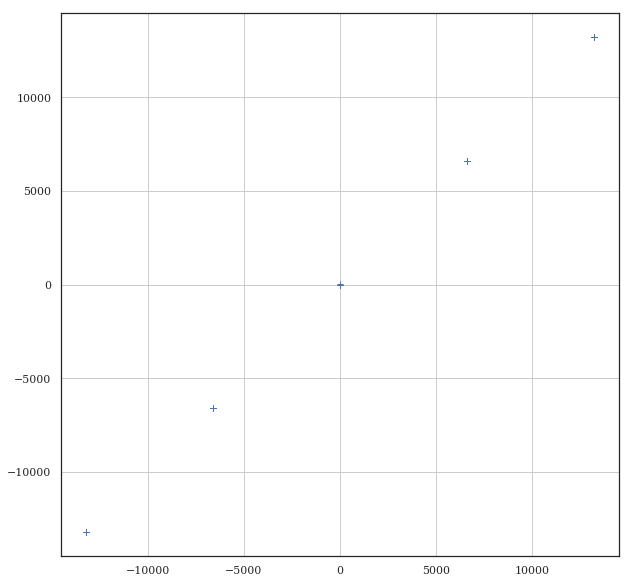

In [163]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(deltax,deltay,'b+')
#for qx,qy,txt in zip(isel.rawx,isel.detx,isel.ccdno):
#    ax.text(qx,qy,txt)
ax.grid();

In [61]:
detx2 = 1
detx1 = 600
dety2 = 6593.6457
dety1 = -6593.5733
m = (dety2-dety1)/(detx2-detx1)

In [62]:
m*(300-detx1) + dety1

11.043895325543417

In [63]:
m*(900-detx1) + dety1

-13198.190495325543